I. Set Up

In [2]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import ipywidgets as widgets
from IPython.display import clear_output
import statistics
from PIL import Image
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
from sherpa.astro import ui
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
# CUSTOM Imports
from data_extraction_functions import *
from data_exploration_functions import *
from data_representation_functions import *

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', options=('All', 'Bona'), value='All')

Filter for N > 25 length

In [2]:
# Set ID
set_id = set_widget.value
# Reduce data for useful input to data representation
df_eventfiles = pd.read_csv(f'{global_path}/{set_id}/eventfiles-{set_id}.csv')
df_properties = pd.read_csv(f'{global_path}/{set_id}/properties-{set_id}.csv')
df_eventfiles_input, df_properties_input = data_reduction_fun(df_eventfiles, df_properties,global_path,set_id, min_counts = 25,unique_ids=True)

# df_eventfiles.to_csv(f'{global_path}/{set_id}/eventfiles-{set_id}.csv',index=False)
# df_properties.to_csv(f'{global_path}/{set_id}/properties-{set_id}.csv',index=False)

# # filter rows where there are less than 30 identical values in column 'B'
# mask = df['B'].isin(counts[counts >= 30].index)

# # create new DataFrame without the filtered rows
# new_df = df[mask]



In [6]:
print(len(df_eventfiles_input['obsreg_id'].unique()))
print(len(df_properties_input['obsreg_id'].unique()))
print(len(df_properties_input['obsreg_id']))

# count unique values in the 'obsreg_id' column
print(len(df_properties_input['obsreg_id'].unique())) # 11

# count total values in the 'obsreg_id' column
print(len(df_properties_input['obsreg_id'])) # 12

# identify duplicate values in the 'obsreg_id' column
duplicates = df_properties_input[df_properties_input.duplicated(['obsreg_id'], keep=False)]
print(duplicates)

62989
62989
63020
62989
63020
       cnts_aper_b  cnts_aperbkg_b  src_cnts_aper_b   flux_aper_b   hard_hm  \
95356          160              66       165.904303  1.252943e-13  0.914428   
95360           86              21        90.469791  1.252943e-13  0.963148   
96423          253             511       240.714066  2.899196e-14  0.234853   
96436           39             144        34.576335  2.899196e-14  0.224859   
95730           54              49        55.741454  2.057922e-15  0.999375   
...            ...             ...              ...           ...       ...   
85565           94              77        94.278217  1.181298e-13  0.357277   
17704          265            1179       217.610196  5.315461e-14  0.273579   
17703          203            1009       161.987217  5.315461e-14  0.428482   
17684           93              80        92.307372  4.227679e-14  0.833229   
17685          119              99       118.200006  4.227679e-14  0.809494   

        hard_hs   har

Filter Pileup Properties file

In [5]:
# Set ID
set_id = set_widget.value
# Reduce data for useful input to data representation
df_eventfiles = pd.read_csv(f'{global_path}/{set_id}/eventfiles-{set_id}.csv')
df_properties_full = pd.read_csv(f'{global_path}/{set_id}/properties-{set_id}-full.csv')
df_properties_full['obsreg_id'] = df_properties_full['obsid'].astype(str) + '_' + df_properties_full['region_id'].astype(str)
df_properties_pileup = pd.read_csv(f'{global_path}/{set_id}/properties-{set_id}-pileup.csv')
df_properties_pileup['obsreg_id'] = df_properties_pileup['obsid'].astype(str) + '_' + df_properties_pileup['region_id'].astype(str)
df_properties = df_properties_full[~df_properties_full['obsreg_id'].isin(df_properties_pileup['obsreg_id'].unique())]

df_properties.to_csv(f'{global_path}/{set_id}/properties-{set_id}.csv',index=False)



In [2]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# Define the sky position in equatorial coordinates (RA and Dec in degrees)
ra = 0.032141223071846525 # 10.68458
dec = 50.10557203183708 # 41.26917

# Convert the sky position to the ICRS format using astropy
icrs_coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')

# Print the ICRS coordinates in decimal degrees
print(icrs_coord.ra.deg, icrs_coord.dec.deg)

0.032141223071846525 50.10557203183708


CSC Products

In [6]:
def cscproducts_plots_fun(df_eventfiles_input,id_name):
    try:
        # IDs
        obsid = id_name.split("_")[0]
        regid = id_name.split("_")[1]
        # Lightcurve
        plt.subplots(figsize=(15, 3))
        lc_filename = [lcurve for lcurve in glob.iglob(f'{global_path}/{set_id}/eventdata/acisf*lc3.fits.gz') if str(obsid) in lcurve and str(regid) in lcurve][0]
        pha_filename = [spec for spec in glob.iglob(f'{global_path}/{set_id}/eventdata/acisf*pha3.fits.gz') if str(obsid) in spec and str(regid) in spec][0]
        img_filename = [imag for imag in glob.iglob(f'{global_path}/{set_id}/eventdata/acisf*regimg3.fits.gz') if str(obsid) in imag and str(regid) in imag][0]

        
        with fits.open(lc_filename) as hdul_lc:
            lc3 = hdul_lc[1].data
            bg3 = hdul_lc[2].data
            plt.plot(lc3['Time'],lc3['COUNT_RATE'])
            plt.xlabel('Time [s]')
            plt.ylabel('Count rate [counts/s]')
            plt.title(f'ObsID: {obsid}, RegID: {regid}')
            plt.errorbar(lc3['Time'],lc3['COUNT_RATE'],lc3['COUNT_RATE_ERR'])
            plt.show()

        ui.load_pha(pha_filename)
        ui.ignore('0.:0.5,8.0:')
        ui.subtract()
        ui.notice_id(1,0.3,7.)
        ui.group_counts(10)
        ui.set_ylog()
        ui.set_xlog()
        ui.plot_data()
        plt.xlim(1E-1,10)  
        plt.title(f'ObsID: {obsid}, RegID: {regid}')
        plt.show()

        with fits.open(img_filename) as hdul_img:
            img3 = hdul_img[0].data
            plt.imshow(img3, cmap='gray')
            #plt.colorbar()
            plt.title(f'ObsID: {obsid}, RegID: {regid}')
            plt.show()

        
    except: 
        print(f'Failed: {id_name}')


def hist2D_Et(df_eventfile_input, id_name, nbins_E, nbins_t,norm = 'none', plot = True):
    # Copy df
    df = df_eventfile_input.copy()
    df.sort_values(by='time', inplace = True) 
    df.reset_index(drop=True, inplace = True)
    # Define histogram boundaries
    E_start = np.log10(500)
    E_end = np.log10(7000)
    t_start = 0
    t_end = 1
    # IDs
    obsid = id_name.split("_")[0]
    regid = id_name.split("_")[1]
    # Eventfile length and duration
    N_length = len(df) 
    T_duration = max(df["time"])-min(df["time"])
    # Add E, t column
    df["E"] = np.log10(df["energy"])
    df["t"] = (df["time"]-min(df["time"]))/(max(df["time"])-min(df["time"]))
    # Add Et histogram
    hist_Et = np.histogram2d(df["t"],df["E"],range = [[t_start,t_end],[E_start, E_end]],bins=(nbins_t,nbins_E)) 
    if norm == 'minmax':
        feature = (hist_Et[0]-np.min(hist_Et[0]))/(np.max(hist_Et[0])-np.min(hist_Et[0]))
    elif norm == 'none':
        feature = hist_Et[0]
    if plot == True:
        colmap = 'plasma'
        plt.imshow(feature.T, origin='lower', extent=[0, 1, E_start, E_end], cmap=colmap,norm=LogNorm())
        #plt.colorbar()
        plt.xlabel('Time')
        plt.ylabel('Log10(Energy)')
        plt.title(f'ObsID: {obsid}, RegID: {regid}')
        plt.show()
    return feature
        

def hist3D(df_eventfile_input, id_name, nbins_E, nbins_t, nbins_dt, plot = True):
    # Copy df
    df = df_eventfile_input.copy()
    df.sort_values(by='time', inplace = True) 
    df.reset_index(drop=True, inplace = True)
    # Define histogram boundaries
    E_start = np.log10(500)
    E_end = np.log10(7000)
    t_start = 0
    t_end = 1
    dt_start = 0
    dt_end = 1
    # IDs
    obsid = id_name.split("_")[0]
    regid = id_name.split("_")[1]
    # Eventfile length and duration
    N_length = len(df) 
    T_duration = max(df["time"])-min(df["time"])
    # Add E, t, dt columns
    df["E"] = np.log10(df["energy"])
    df["t"] = (df["time"]-min(df["time"]))/(max(df["time"])-min(df["time"]))
    df["delta_time"] = df['time'].diff().shift(-1)
    df = df[df["delta_time"].notna()]
    df["dt"] = (df['delta_time'] - df['delta_time'].mean()) / df['delta_time'].std() 
    df["dt"] = (df["dt"]-min(df["dt"]))/(max(df["dt"])-min(df["dt"]))
    # Add Et histogram
    hist3D, edges = np.histogramdd((df["t"], df["E"], df["dt"]), range = [[t_start,t_end],[E_start, E_end], [dt_start, dt_end]],bins=(nbins_t,nbins_E, nbins_dt))
    # Create feature
    feature = hist3D
    # Plot
    colmap = 'plasma'
    if plot == True:
        fig = plt.figure(figsize=(10, 10),constrained_layout = True)
        fig.suptitle(f'ObsID: {obsid}, RegID: {regid}')
        # Plot the E-t projection
        ax1 = fig.add_subplot(2, 2, 1)
        ax1.imshow(hist3D.sum(axis=2).T, origin='lower', extent=[t_start,t_end, E_start, E_end],cmap=colmap,norm=LogNorm())
        ax1.set_xlabel('t')
        ax1.set_ylabel('E')
        ax1.set_title('E-t Projection')

        # Plot the dt-t projection
        ax2 = fig.add_subplot(2, 2, 2)
        ax2.imshow(hist3D.sum(axis=1).T, origin='lower', extent=[t_start,t_end, dt_start, dt_end],cmap=colmap,norm=LogNorm())
        ax2.set_xlabel('t')
        ax2.set_ylabel('dt')
        ax2.set_title('dt-t Projection')

        # Plot the YZ projection
        ax3 = fig.add_subplot(2, 2, 3)
        ax3.imshow(hist3D.sum(axis=0), origin='lower', extent=[dt_start,dt_end, E_start, E_end],cmap=colmap,norm=LogNorm())
        ax3.set_xlabel('dt')
        ax3.set_ylabel('E')
        ax3.set_title('E-dt Projection')

        # Plot 3D Histogram
        ax4 = fig.add_subplot(2, 2, 4, projection='3d')
        tt, EE, dtdt = np.meshgrid(edges[0][:-1], edges[1][:-1], edges[2][:-1], indexing='ij')
        tt = np.ravel(tt)
        EE = np.ravel(EE)
        dtdt = np.ravel(dtdt)
        h = np.ravel(hist3D)
        ax4.scatter(dtdt, tt, EE, s=h*50, alpha=0.5, edgecolors='none', c=h, cmap=colmap)
        ax4.set_xlabel('dt')
        ax4.set_ylabel('t')
        ax4.set_zlabel('E')
        ax4.set_title('3D Histogram')
        ax4.view_init(elev=30, azim=45)
        ax4.xaxis.set_ticks_position('bottom')
        ax4.yaxis.set_ticks_position('top')
        ax4.zaxis.set_ticks_position('bottom')
        ax4.invert_xaxis()
        plt.show()
    return feature
  

Failed: 10822_185


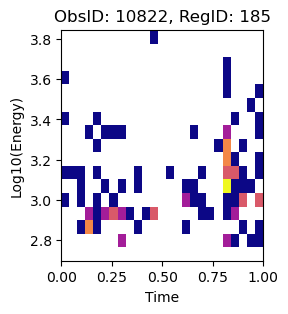

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


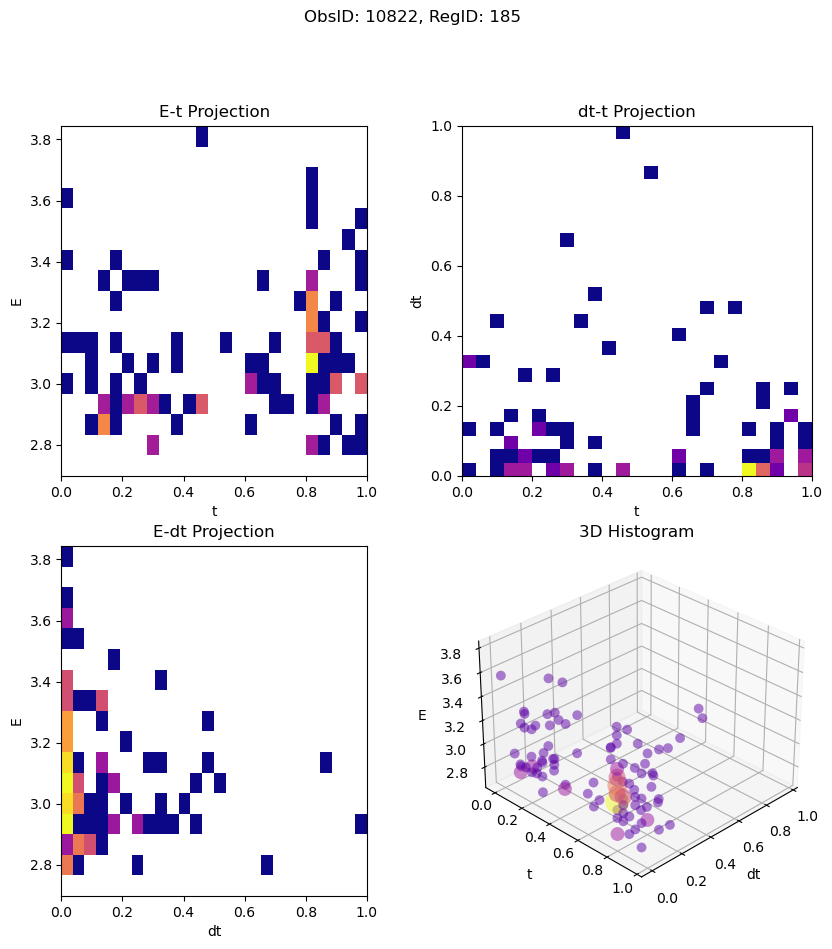

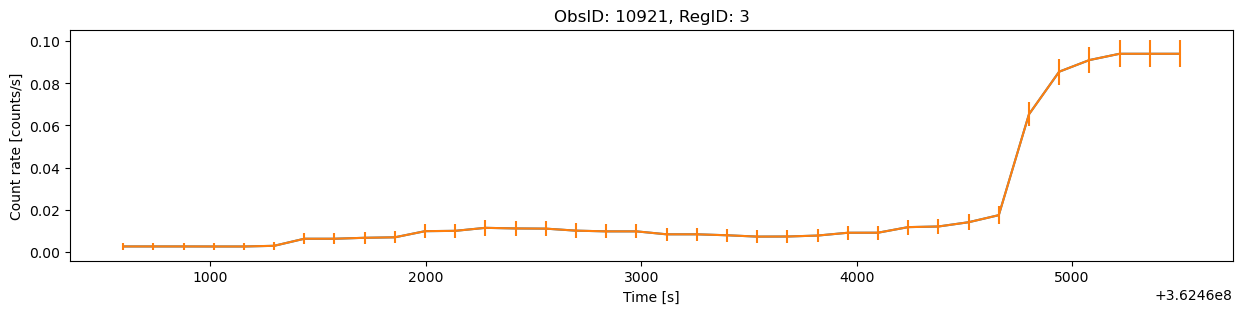

read ARF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf10921_001N022_r0003_arf3.fits
read RMF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf10921_001N022_r0003_rmf3.fits
read background file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf10921_001N023_r0003_pha3.fits
dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:7.9862 Energy (keV)
dataset 1: 0.511:7.9862 -> 0.292:7.9862 Energy (keV)


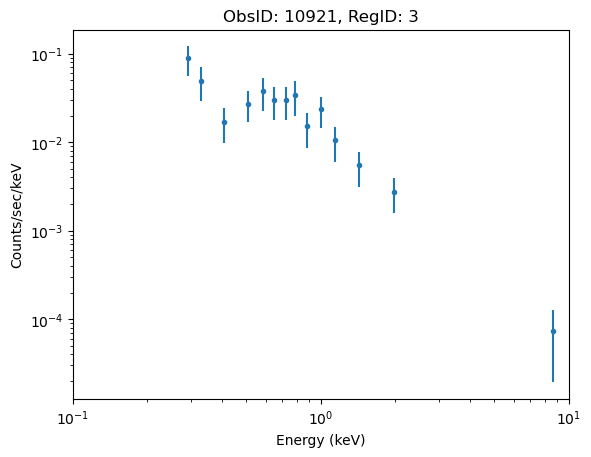

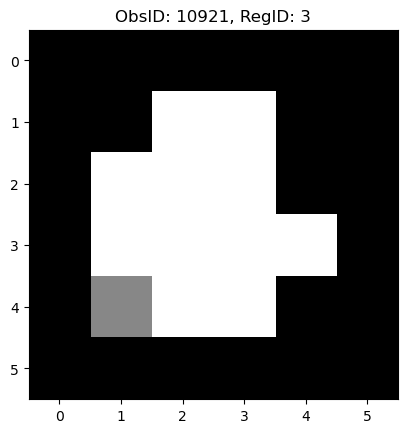

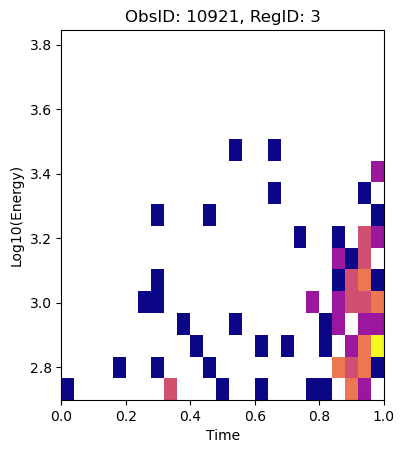

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


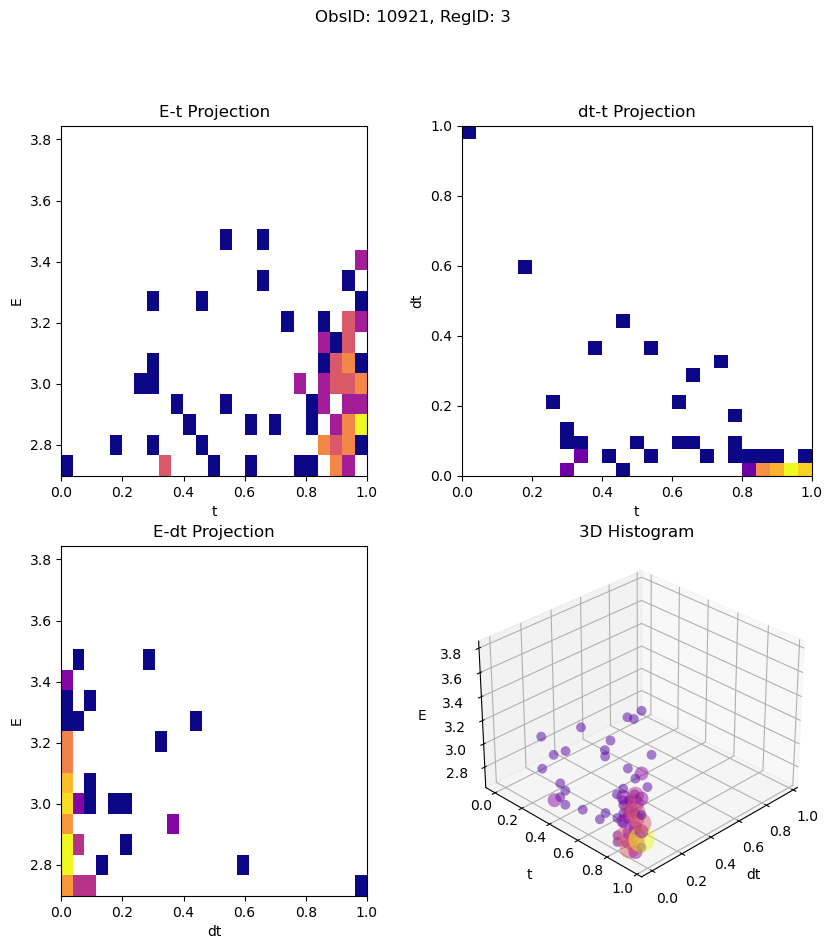

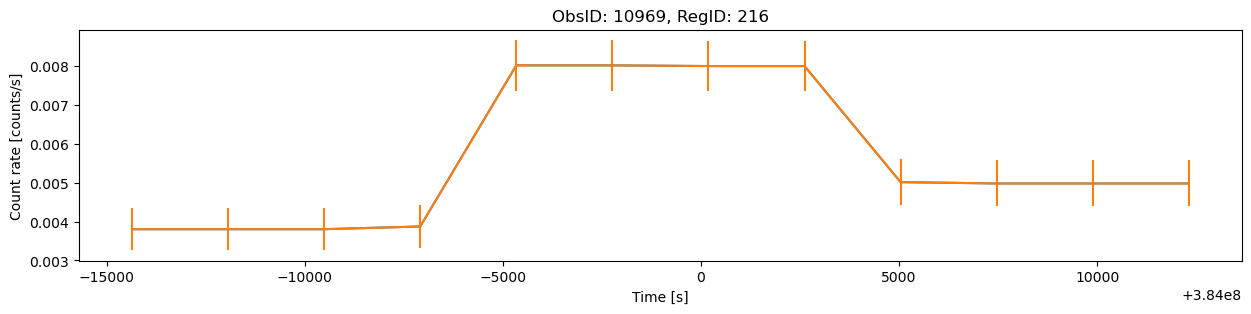

read ARF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf10969_000N021_r0216_arf3.fits
read RMF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf10969_000N021_r0216_rmf3.fits
read background file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf10969_000N022_r0216_pha3.fits
dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:7.9862 Energy (keV)
dataset 1: 0.511:7.9862 -> 0.292:7.9862 Energy (keV)


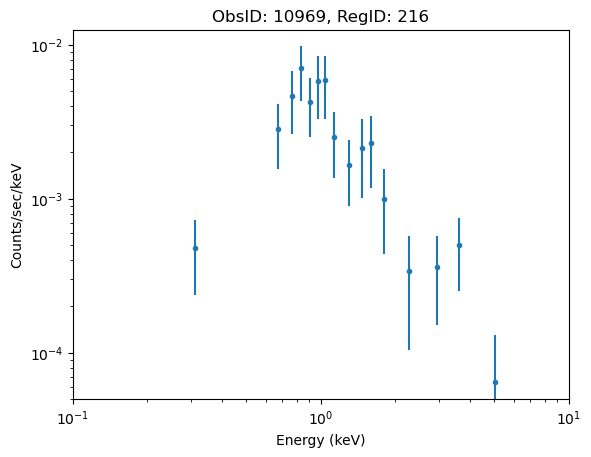

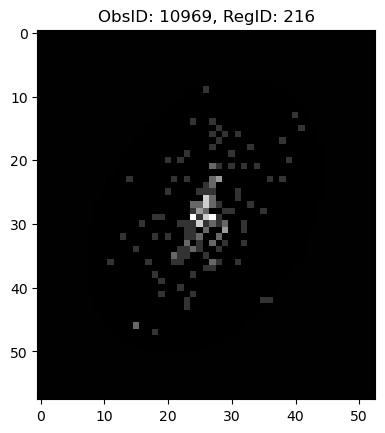

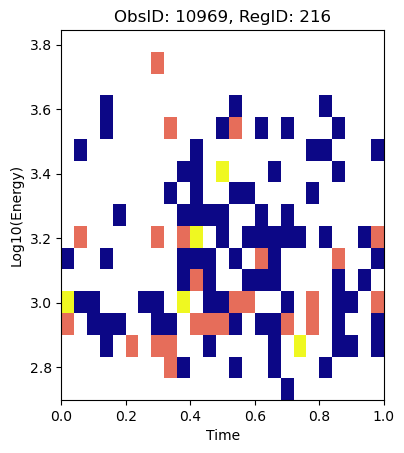

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


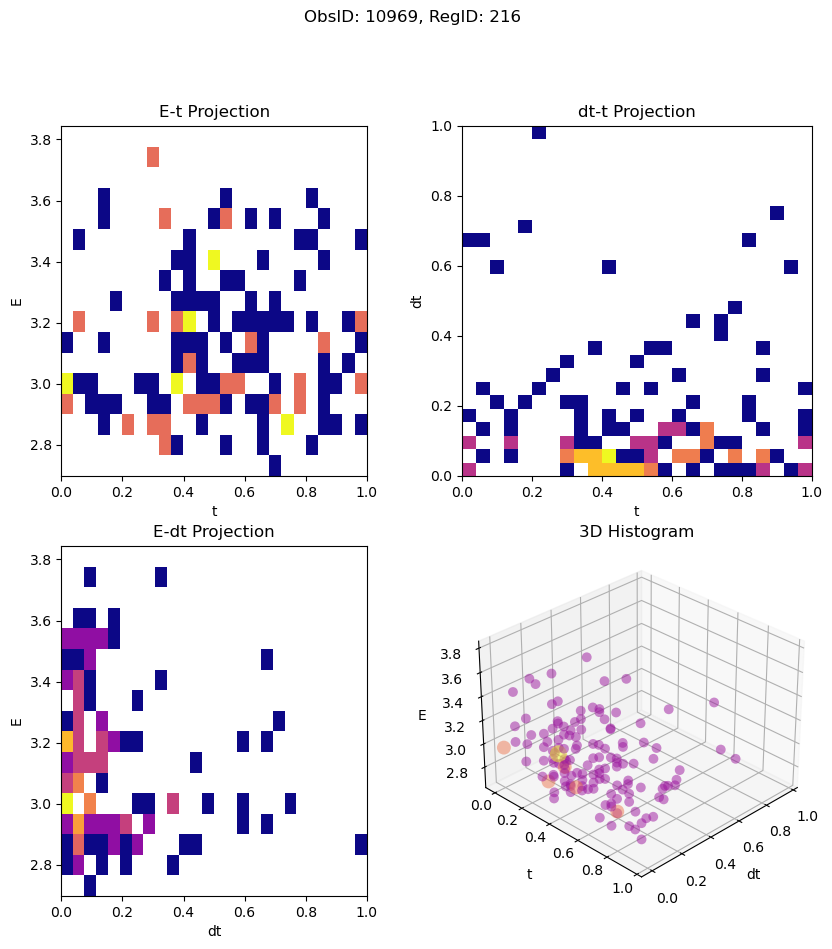

Failed: 10995_21


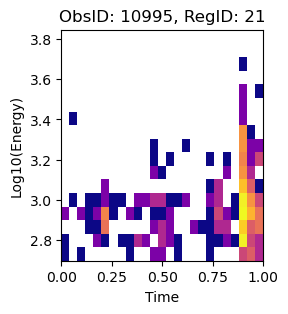

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


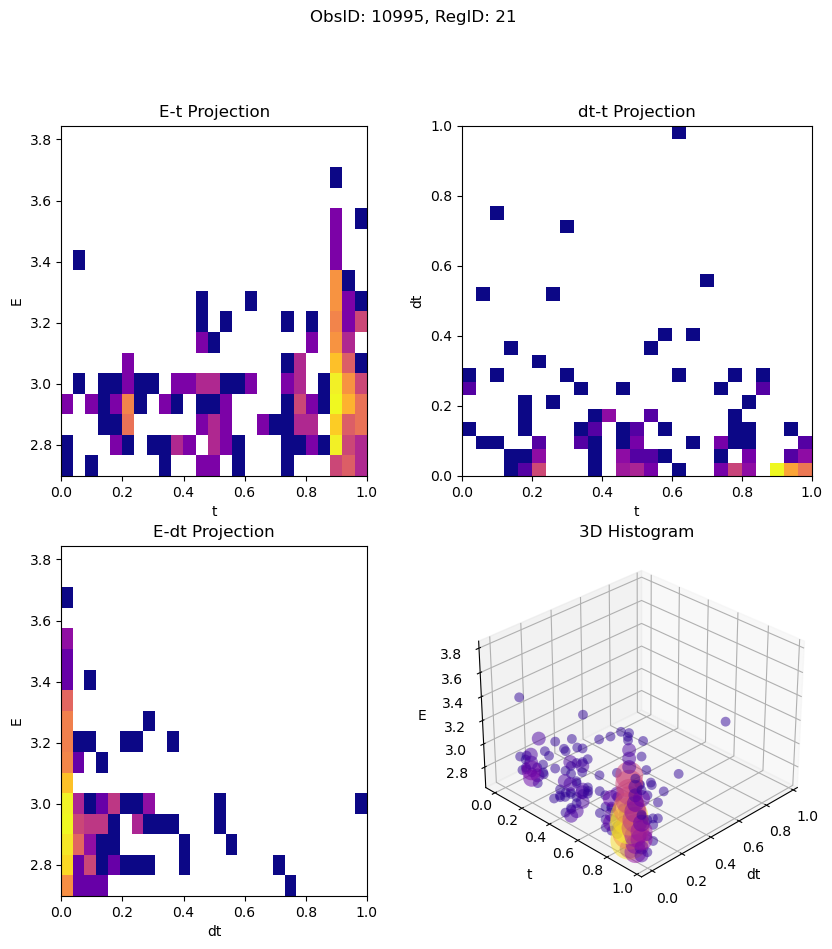

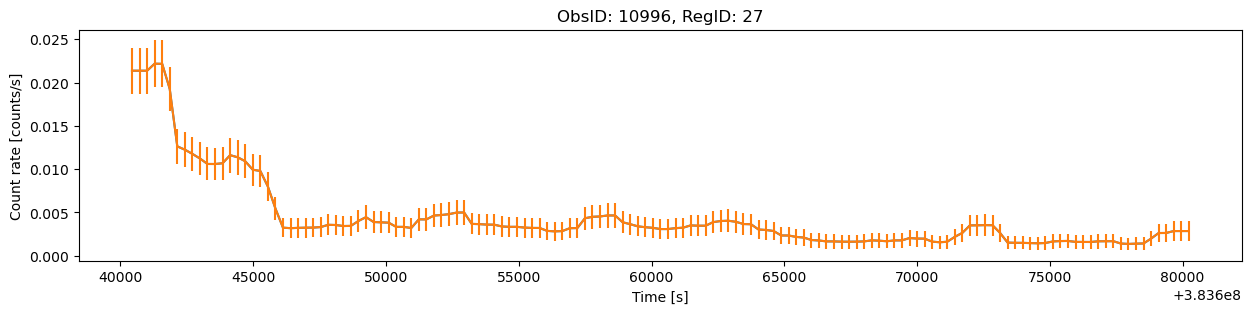

read ARF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf10996_000N021_r0027_arf3.fits
read RMF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf10996_000N021_r0027_rmf3.fits
read background file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf10996_000N022_r0027_pha3.fits
dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:7.9862 Energy (keV)
dataset 1: 0.511:7.9862 -> 0.292:7.9862 Energy (keV)


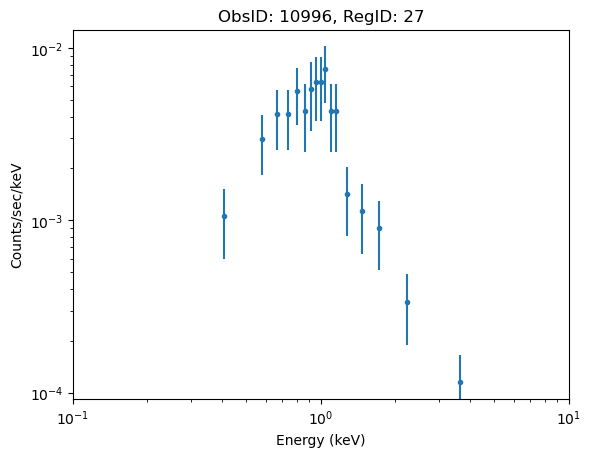

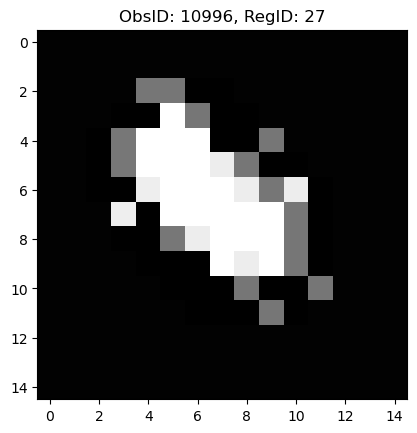

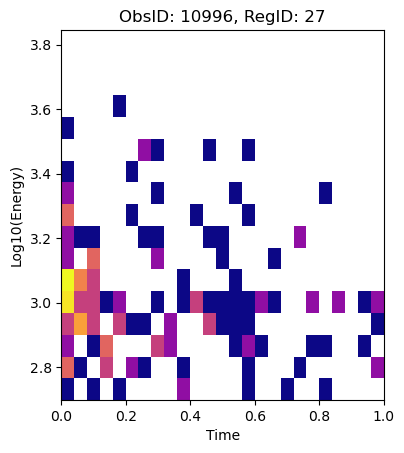

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


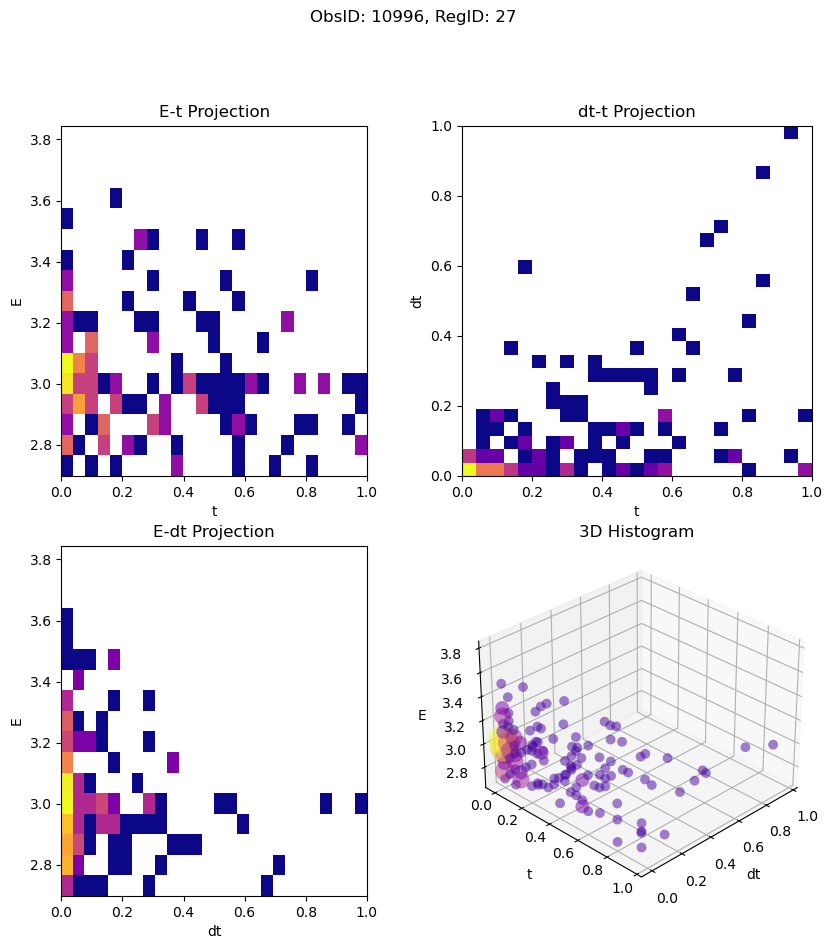

Failed: 10996_5


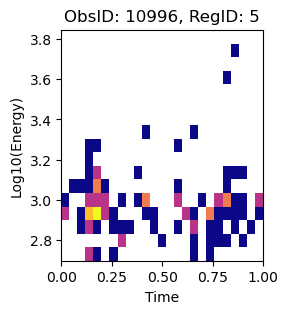

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


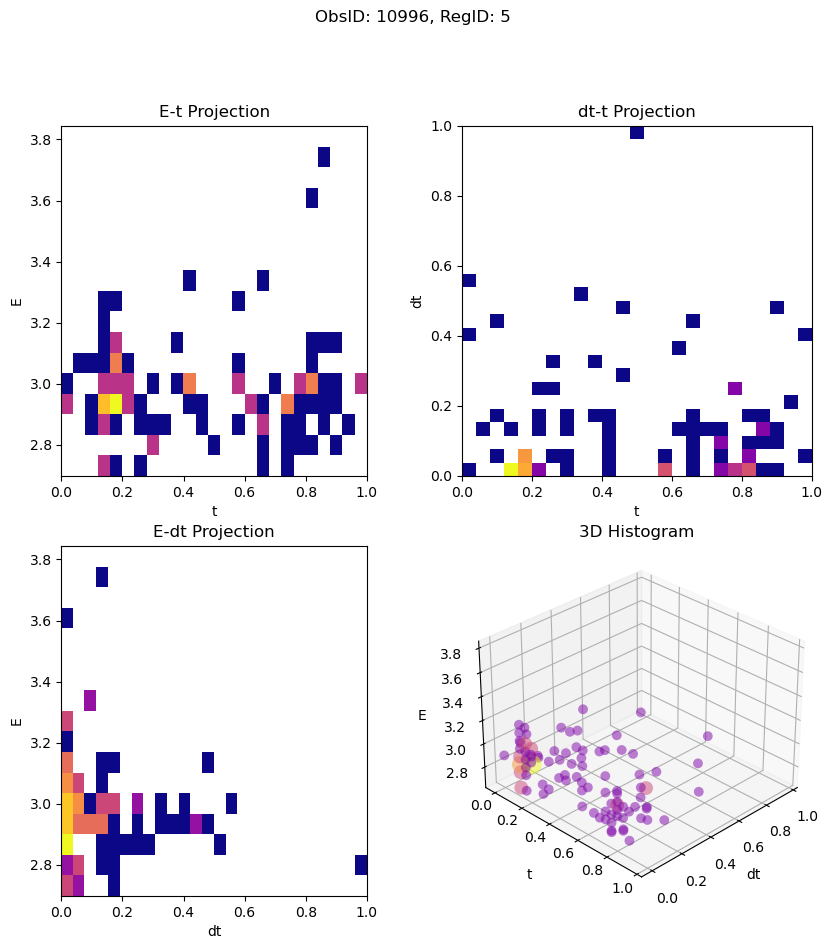

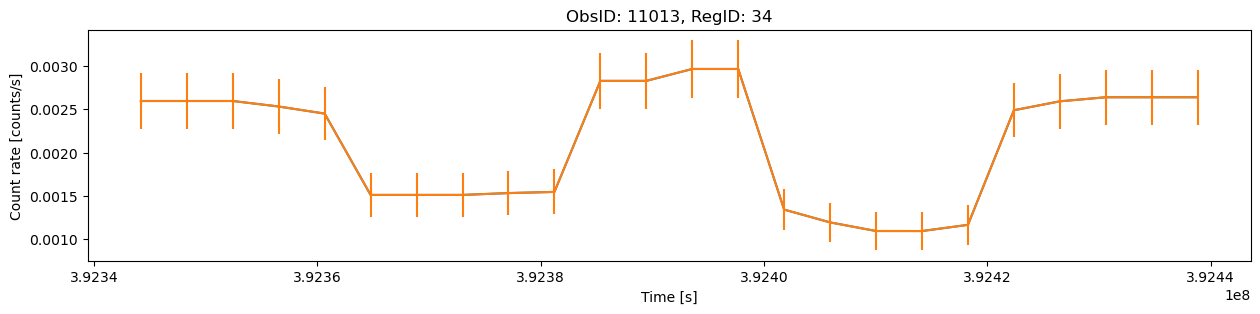

read ARF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf11013_000N023_r0034_arf3.fits
read RMF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf11013_000N023_r0034_rmf3.fits
read background file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf11013_000N024_r0034_pha3.fits
dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:7.9862 Energy (keV)
dataset 1: 0.511:7.9862 -> 0.292:7.9862 Energy (keV)


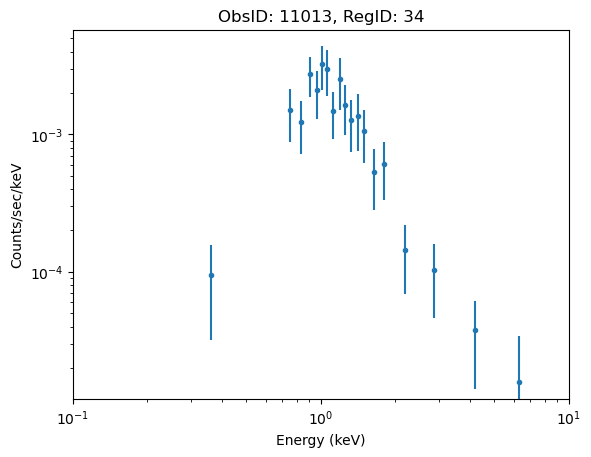

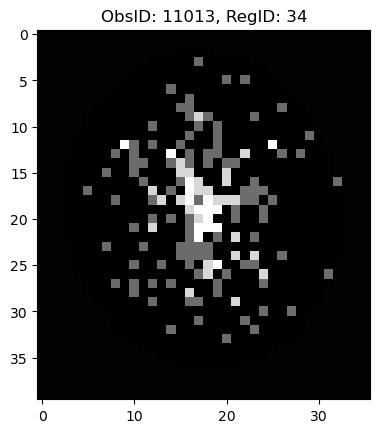

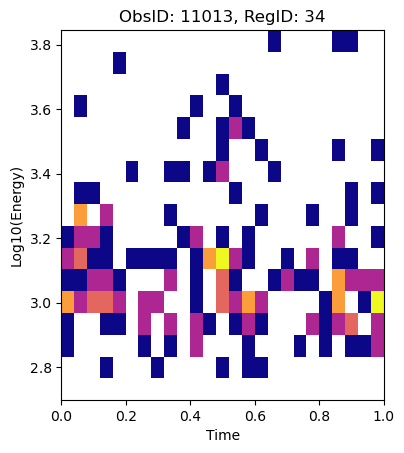

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


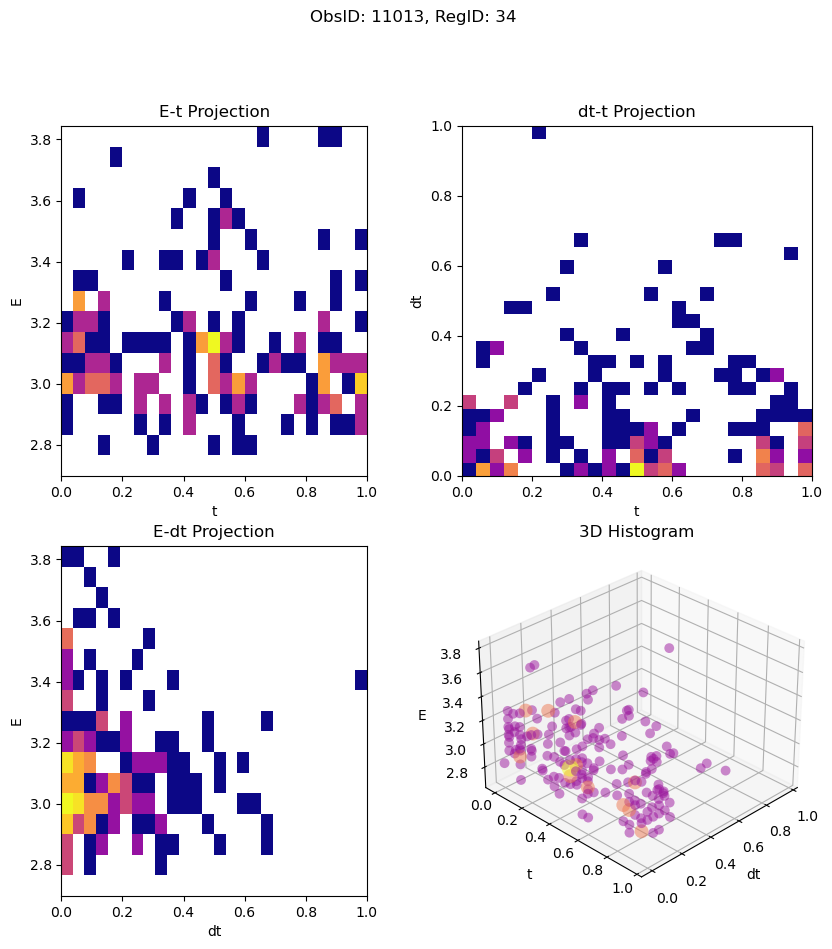

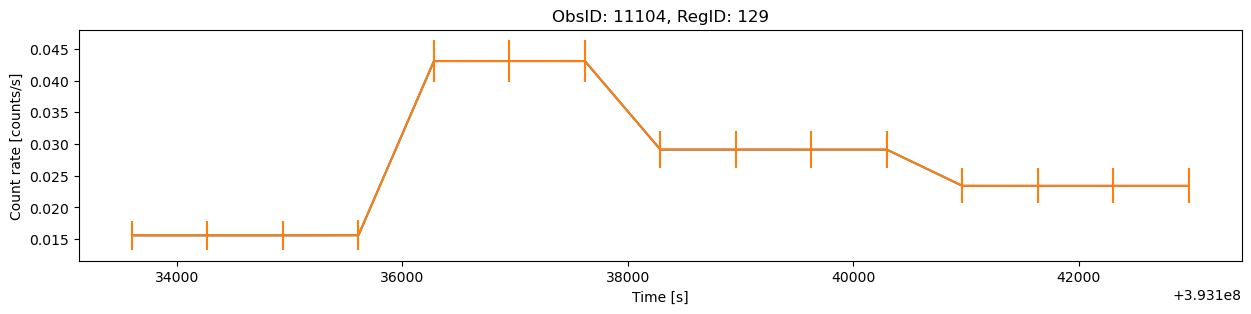

read ARF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf11104_000N021_r0129_arf3.fits
read RMF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf11104_000N021_r0129_rmf3.fits
read background file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf11104_000N022_r0129_pha3.fits
dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:7.9862 Energy (keV)
dataset 1: 0.511:7.9862 -> 0.292:7.9862 Energy (keV)


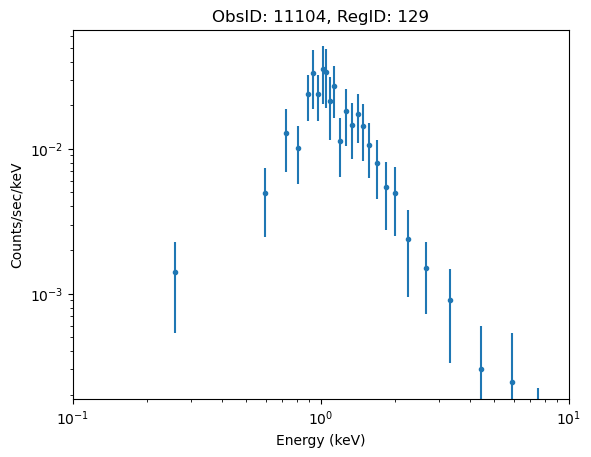

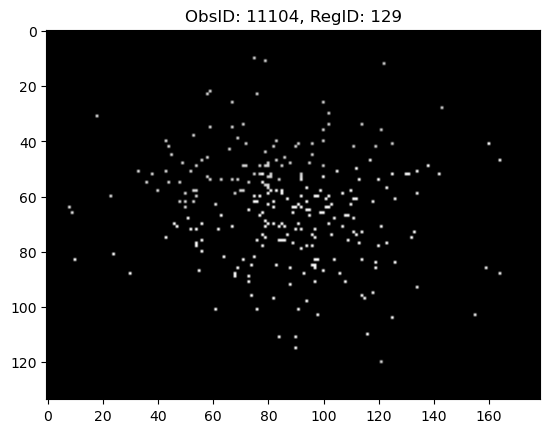

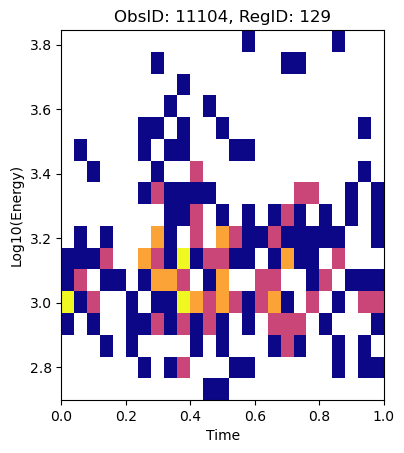

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


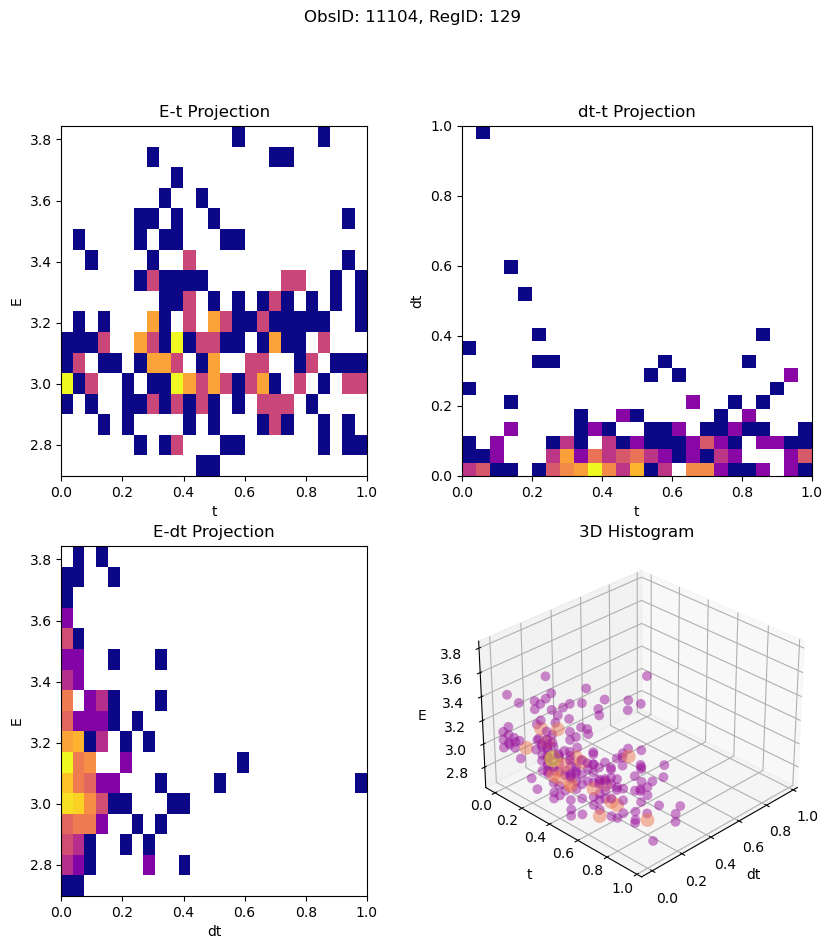

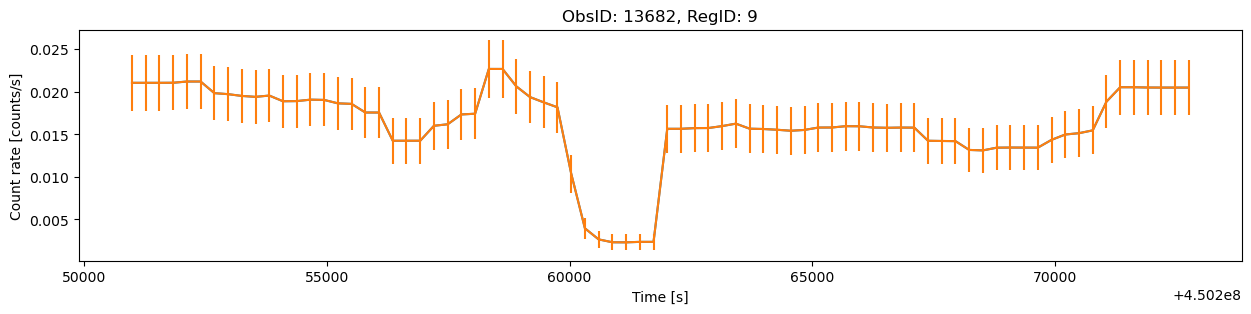

read ARF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf13682_001N022_r0009_arf3.fits
read RMF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf13682_001N022_r0009_rmf3.fits
read background file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf13682_001N023_r0009_pha3.fits
dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:7.9862 Energy (keV)
dataset 1: 0.511:7.9862 -> 0.292:7.9862 Energy (keV)


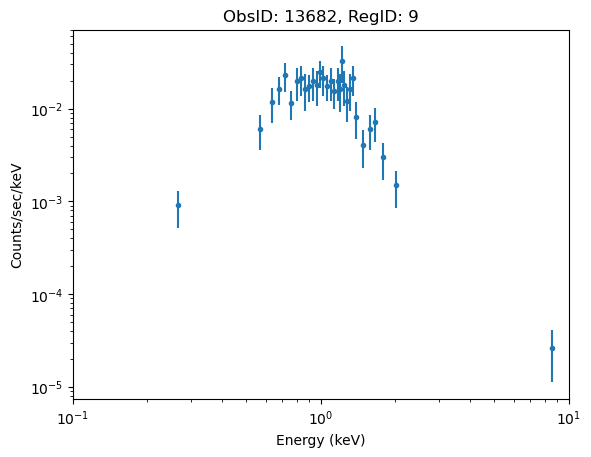

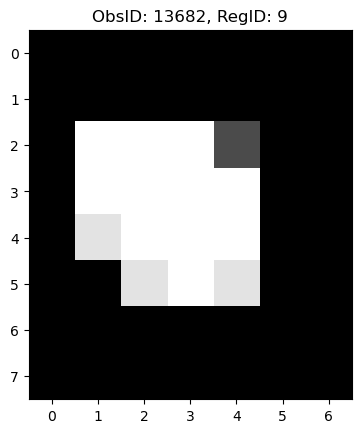

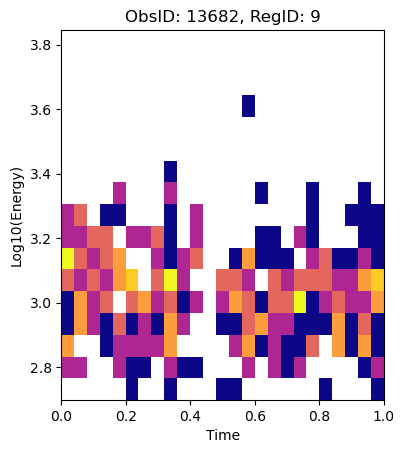

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


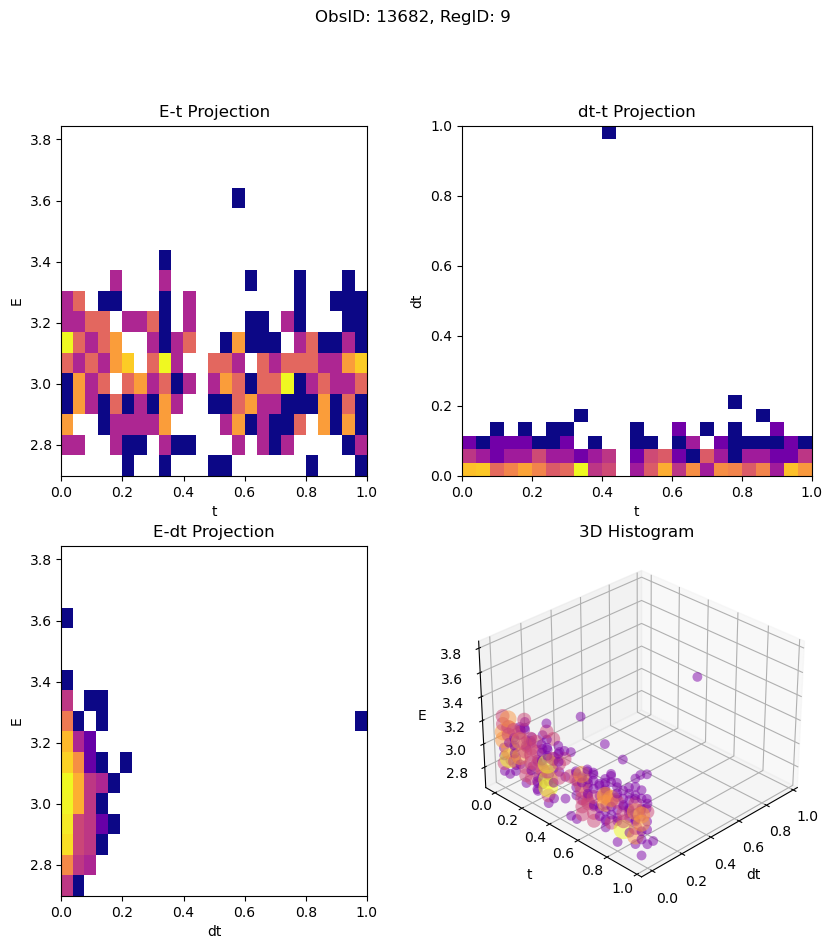

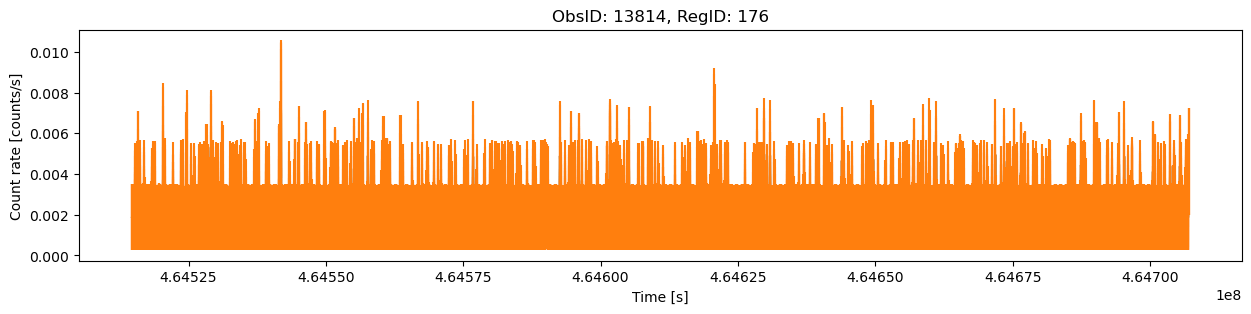

read ARF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf13814_000N021_r0176_arf3.fits
read RMF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf13814_000N021_r0176_rmf3.fits
read background file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf13814_000N022_r0176_pha3.fits
dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:7.9862 Energy (keV)
dataset 1: 0.511:7.9862 -> 0.292:7.9862 Energy (keV)


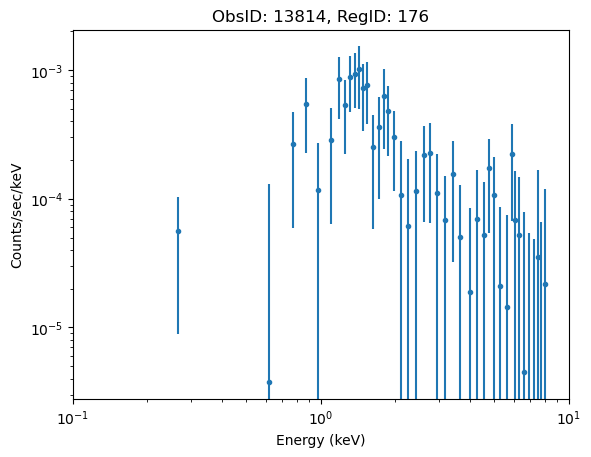

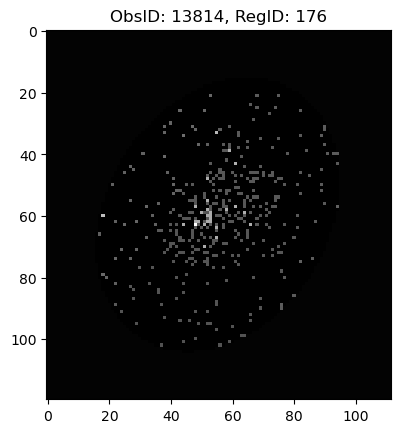

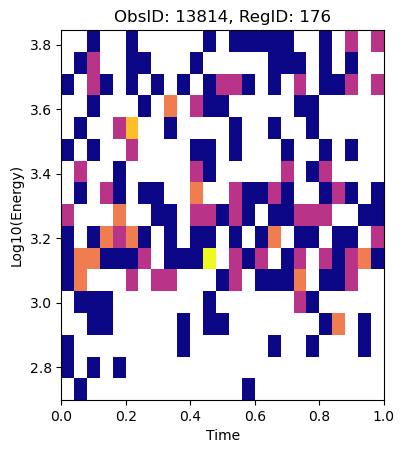

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


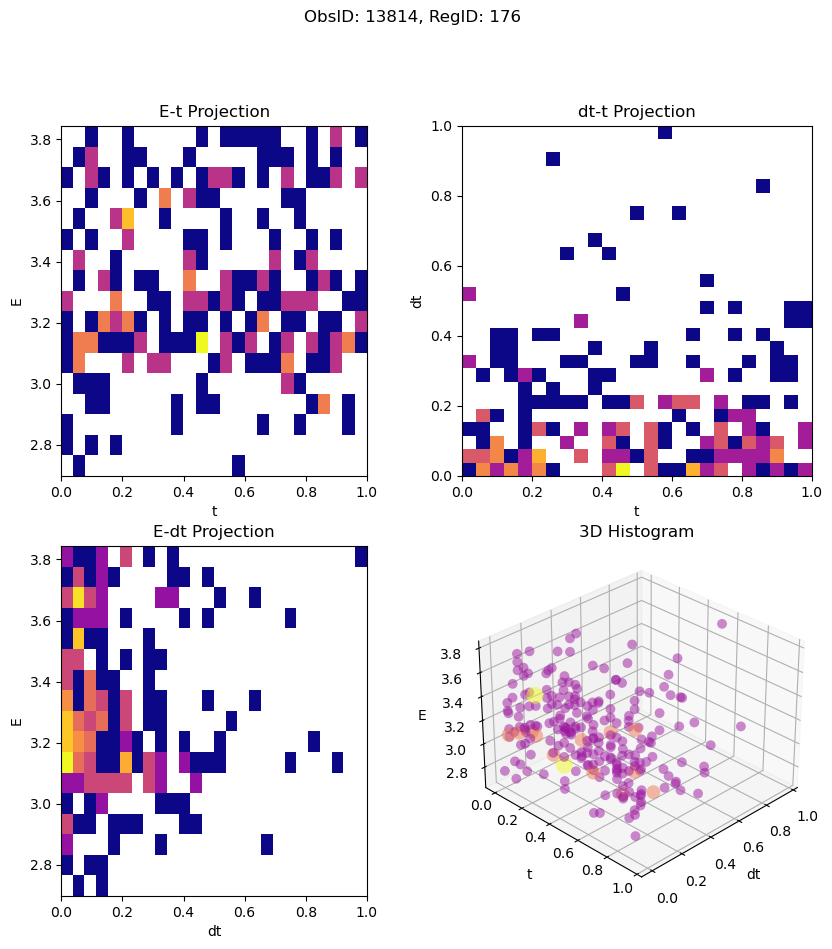

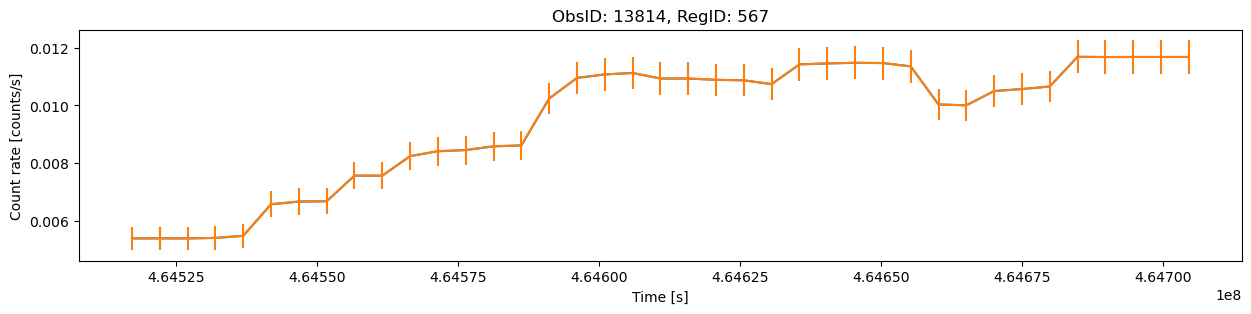

read ARF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf13814_000N021_r0567_arf3.fits
read RMF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf13814_000N021_r0567_rmf3.fits
read background file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf13814_000N022_r0567_pha3.fits
dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:7.9862 Energy (keV)
dataset 1: 0.511:7.9862 -> 0.292:7.9862 Energy (keV)


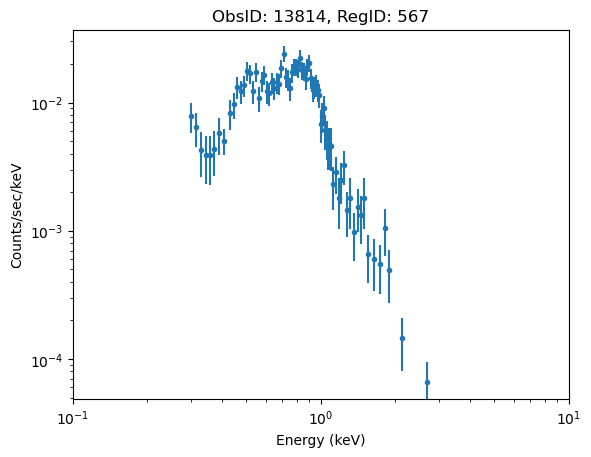

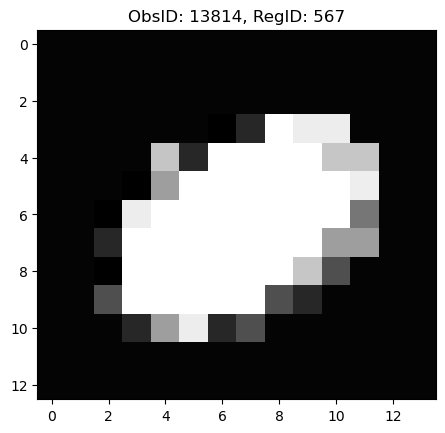

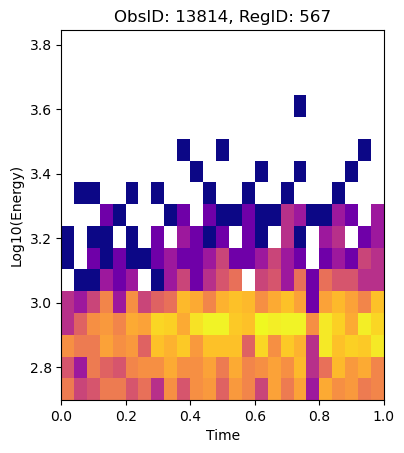

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


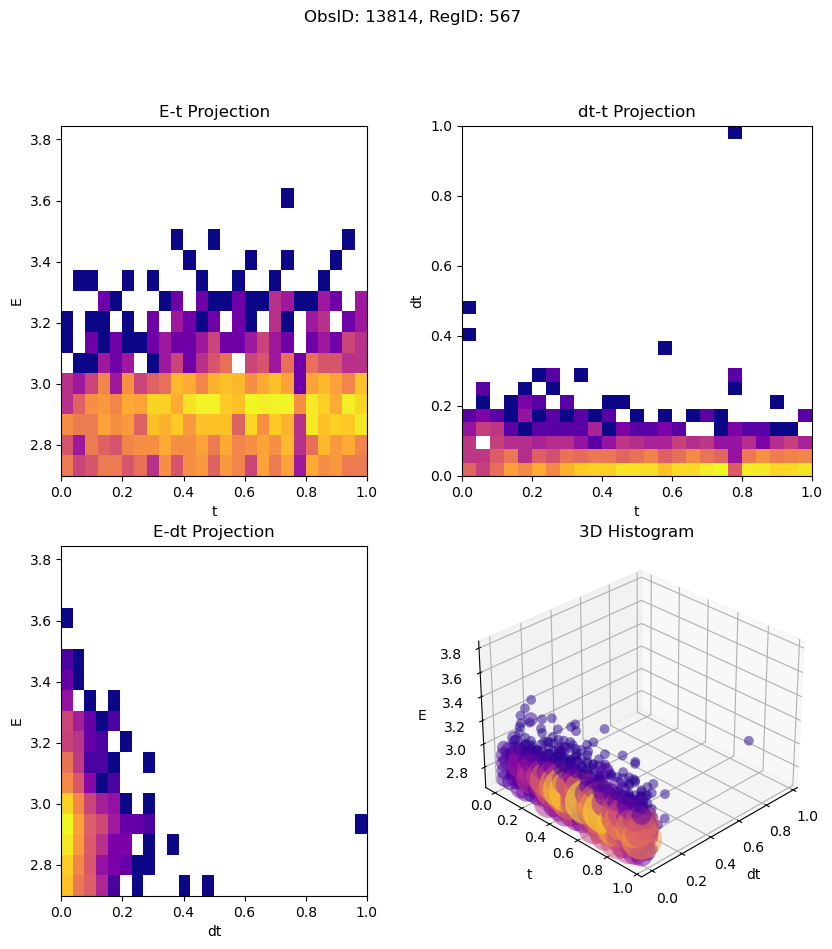

Failed: 14436_54


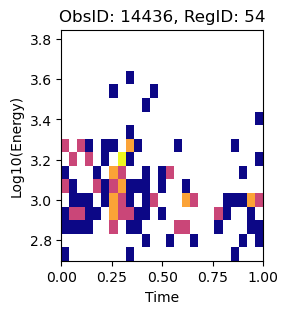

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


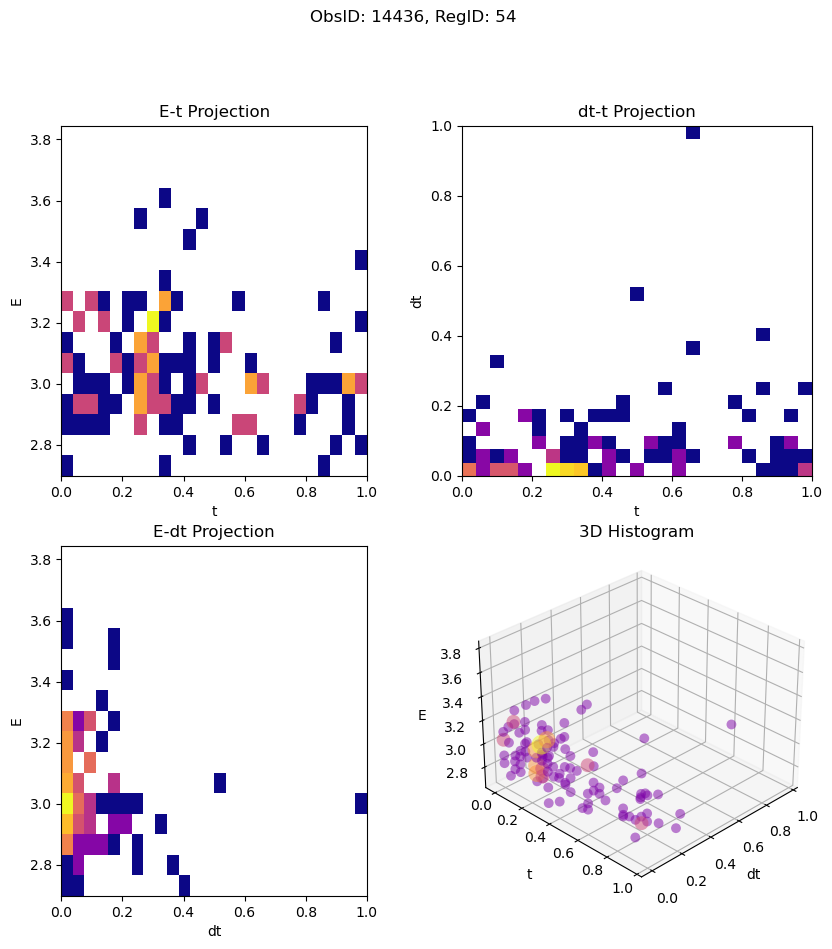

Failed: 14538_5


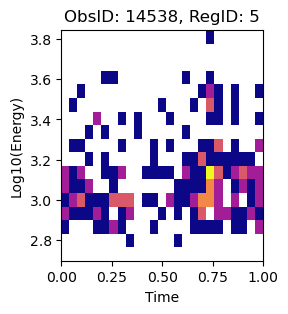

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


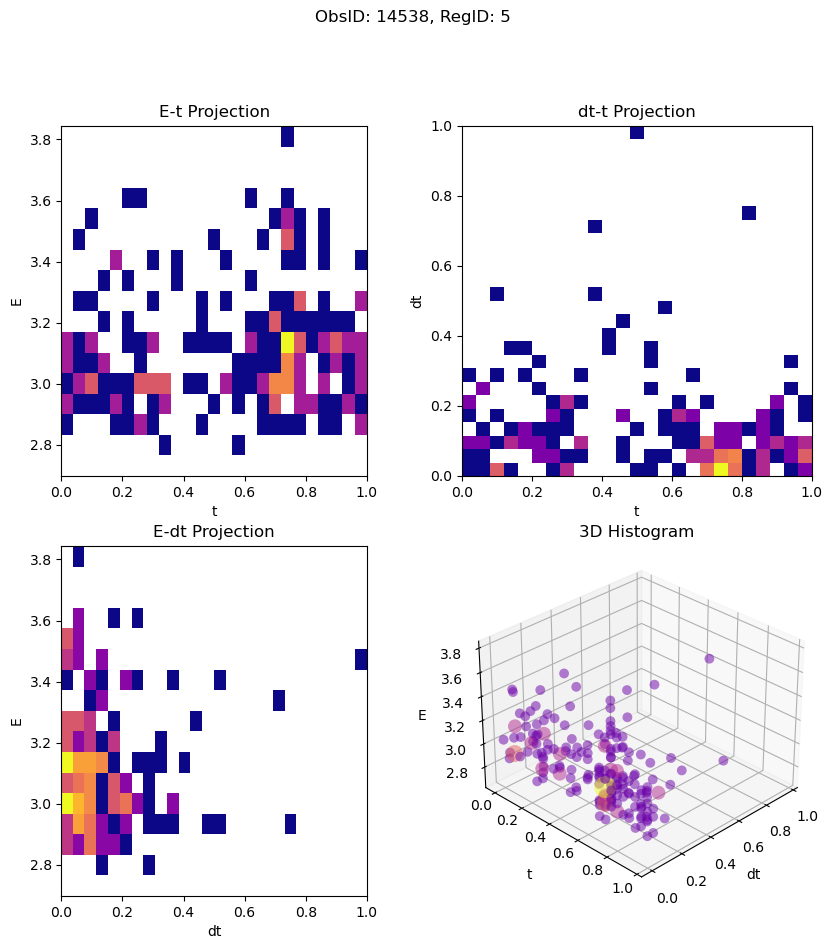

Failed: 2833_53


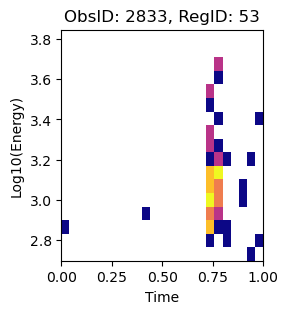

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


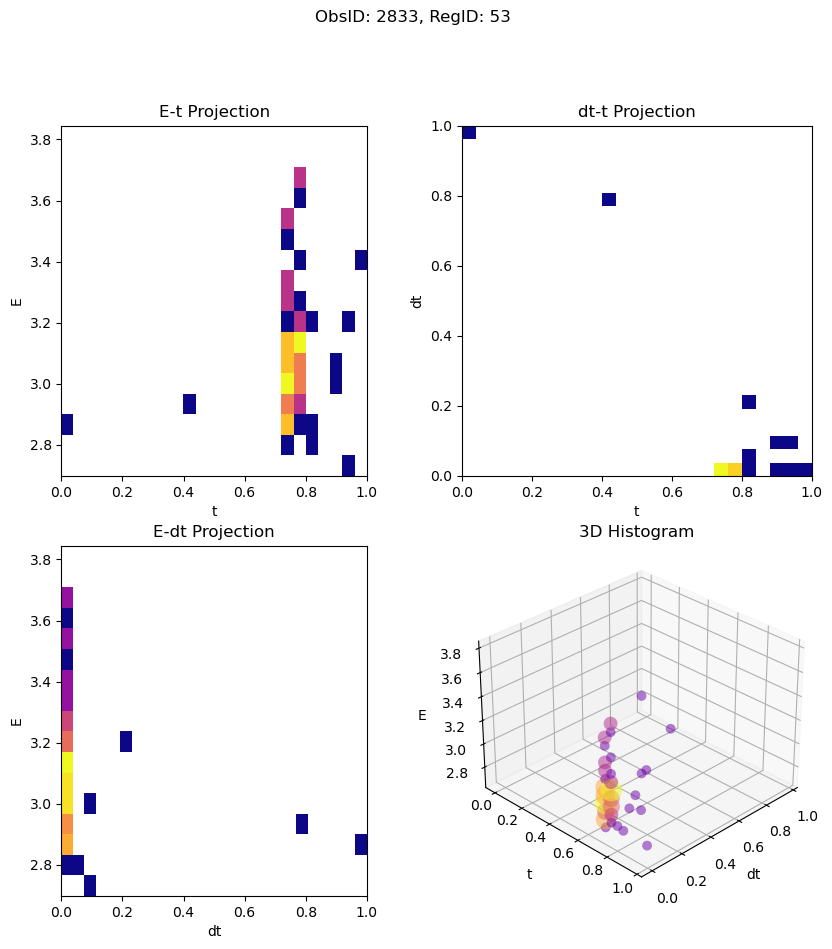

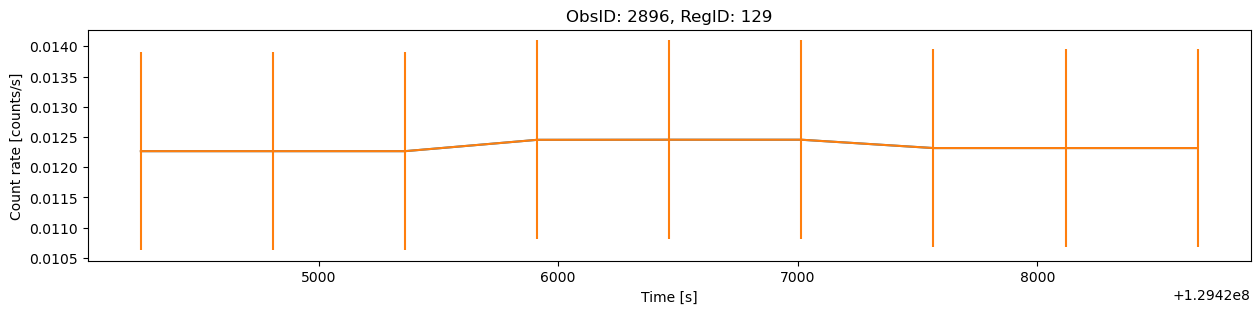

read ARF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf02896_000N022_r0129_arf3.fits
read RMF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf02896_000N022_r0129_rmf3.fits
read background file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf02896_000N023_r0129_pha3.fits
dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:7.9862 Energy (keV)
dataset 1: 0.511:7.9862 -> 0.292:7.9862 Energy (keV)


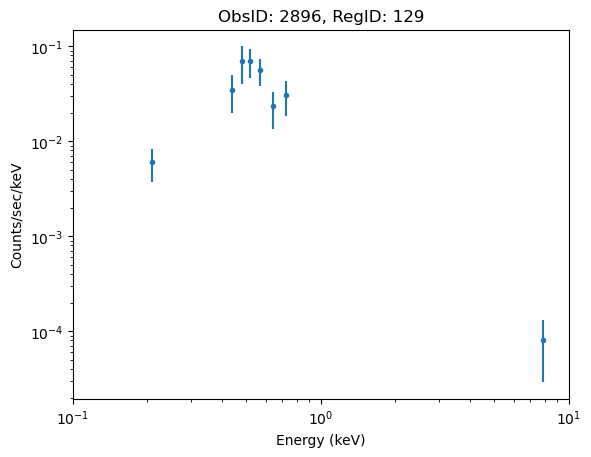

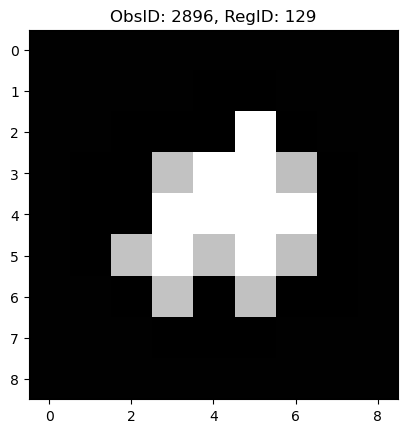

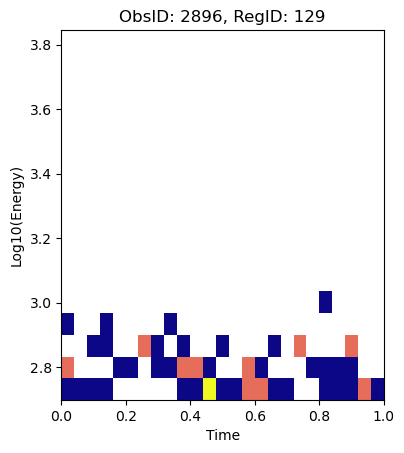

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


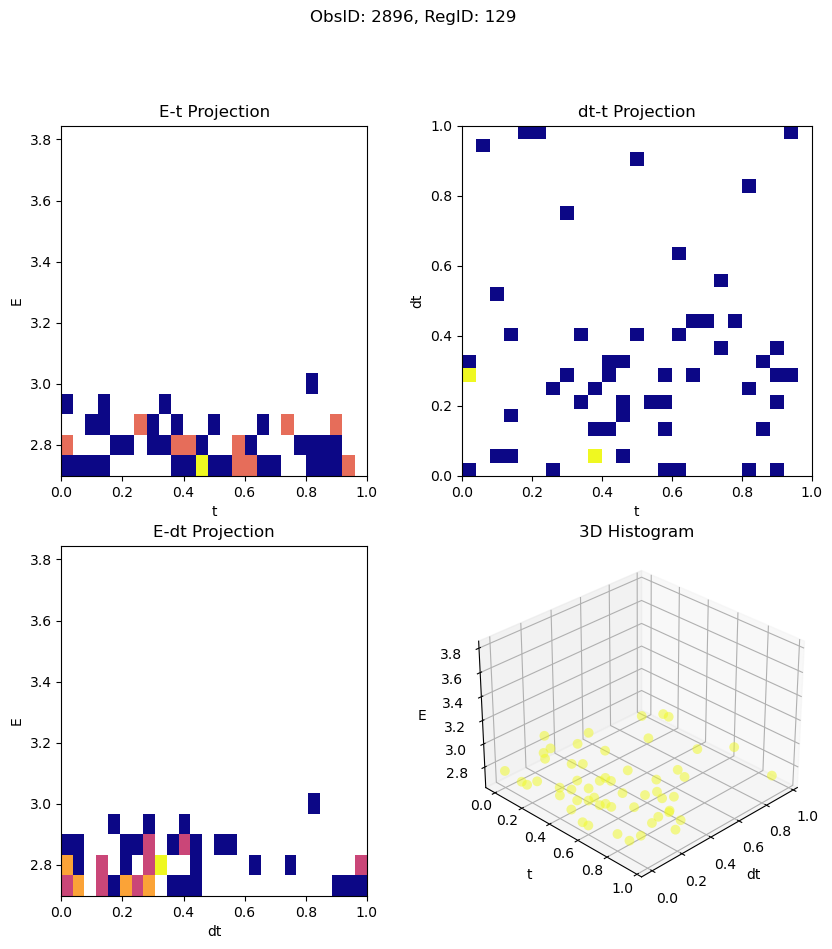

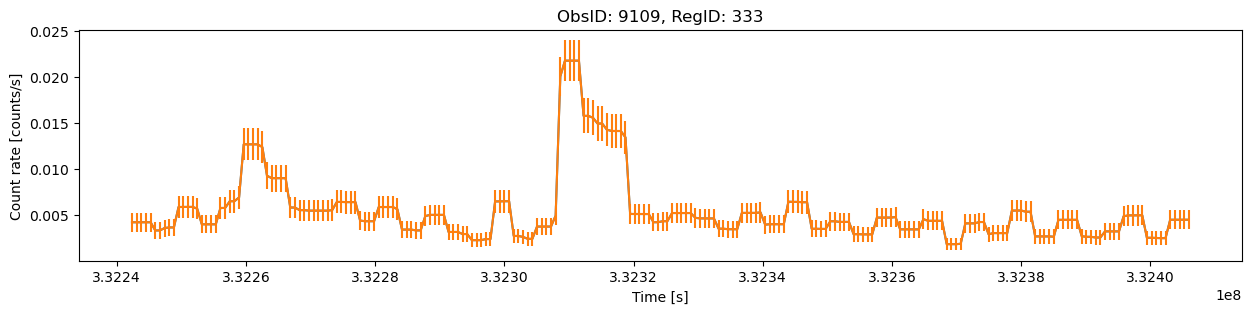

read ARF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf09109_000N022_r0333_arf3.fits
read RMF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf09109_000N022_r0333_rmf3.fits
read background file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf09109_000N023_r0333_pha3.fits
dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:7.9862 Energy (keV)
dataset 1: 0.511:7.9862 -> 0.292:7.9862 Energy (keV)


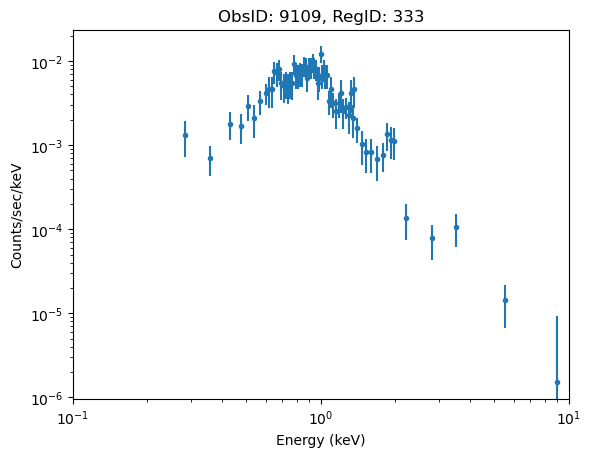

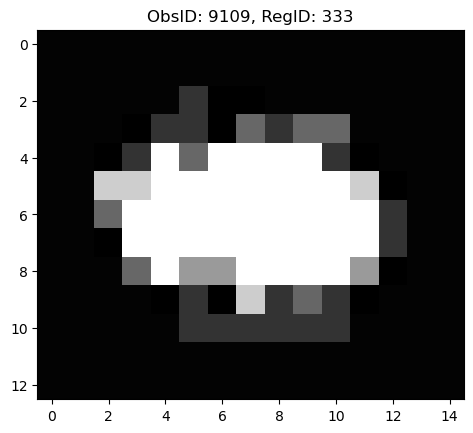

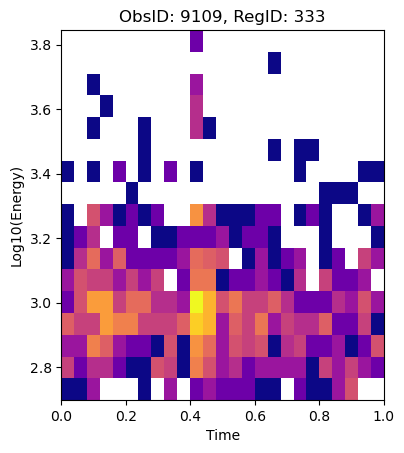

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


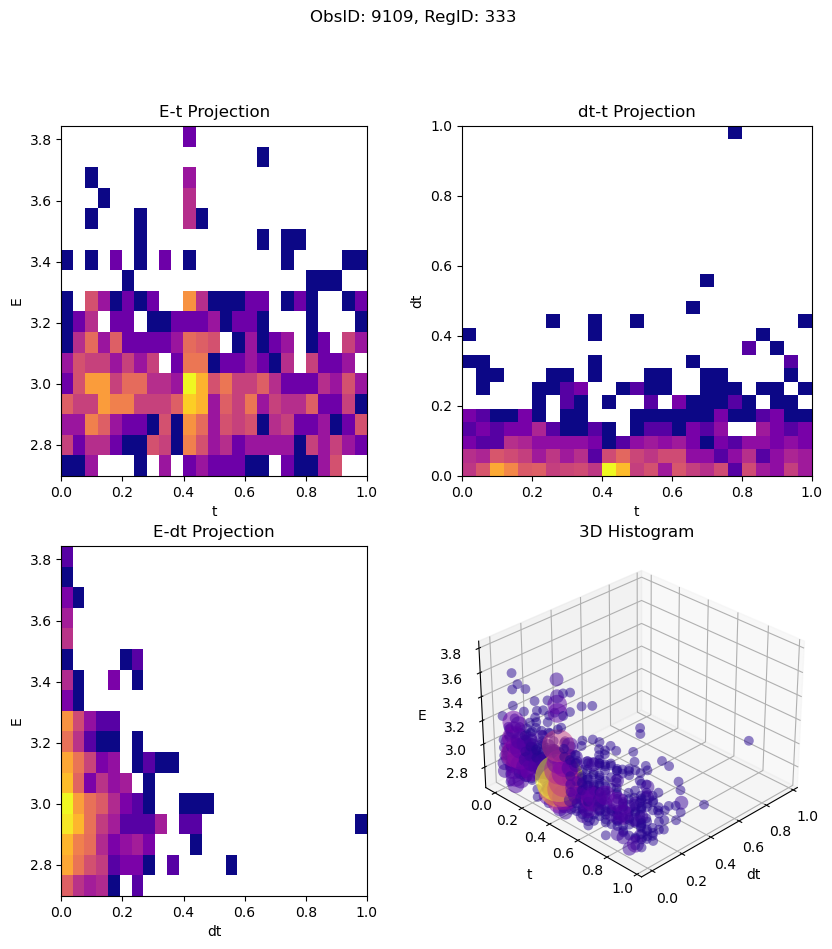

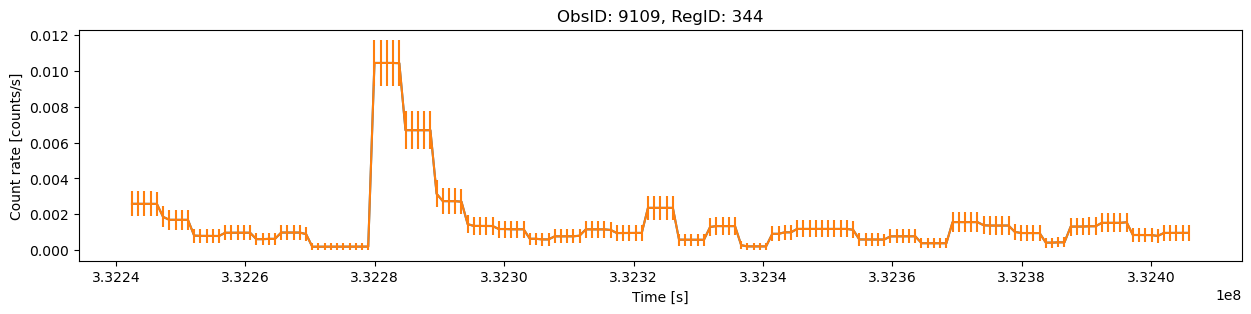

read ARF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf09109_000N021_r0344_arf3.fits
read RMF file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf09109_000N021_r0344_rmf3.fits
read background file /Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Bona/eventdata/acisf09109_000N022_r0344_pha3.fits
dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:7.9862 Energy (keV)
dataset 1: 0.511:7.9862 -> 0.292:7.9862 Energy (keV)


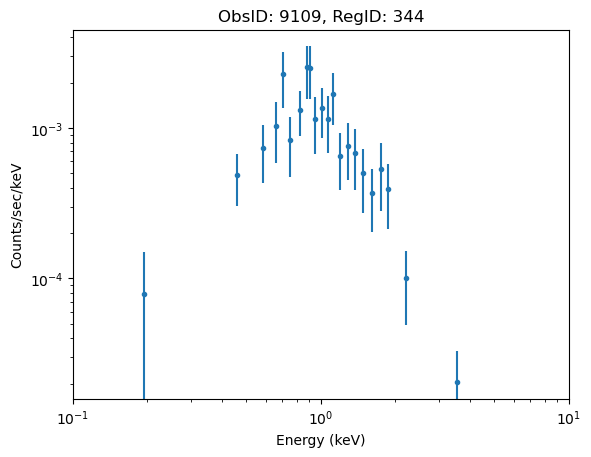

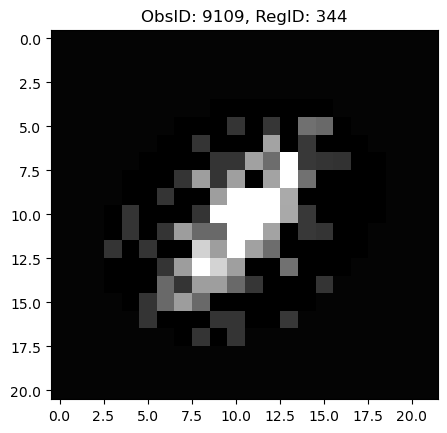

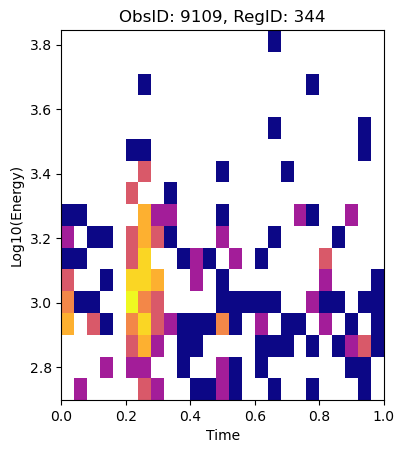

/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


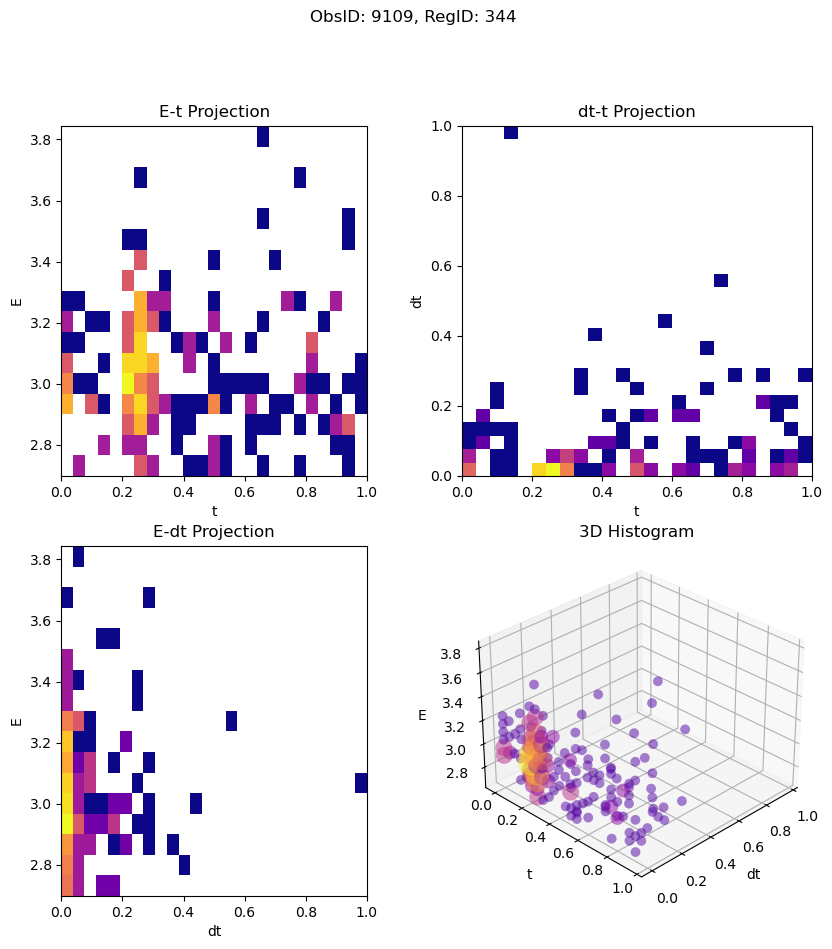

,time,energy,chipx,chipy,obsreg_id
5011,3.322833e+08,763.34050,764,568,9109_344
5012,3.322833e+08,806.55414,759,561,9109_344
5013,3.322833e+08,1892.25480,766,563,9109_344
5014,3.322836e+08,1118.83180,763,596,9109_344
5015,3.322818e+08,842.43915,743,564,9109_344


In [7]:
# Set ID
set_id = set_widget.value

df_eventfiles_input = pd.read_csv(f'{global_path}/{set_id}/eventfiles-input-{set_id}.csv')
df_eventfiles_group = df_eventfiles_input.groupby('obsreg_id')

nbins_E = 17
nbins_t = 25
nbins_dt = 26

for id_name, dfi in df_eventfiles_group:
    cscproducts_plots_fun(dfi,id_name)
    hist2D_Et(dfi, id_name, nbins_E, nbins_t,norm = 'none', plot = True)
    hist3D(dfi, id_name, nbins_E, nbins_t, nbins_dt, plot = True)


dfi.head()